# Simple ML Pipeline: Phosphorylation (phos_y) PTM Prediction

This notebook implements the Milestone 1 baseline: an end-to-end MLP pipeline for residue-level phosphorylation (tyrosine) site prediction. It uses fixed-window sequence encoding plus precomputed embedding/entropy features, protein-wise train/validation/test splits, and imbalance-aware training. Metrics: Precision, Recall, F1, AUPRC.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    average_precision_score, precision_recall_curve, confusion_matrix,
)
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import warnings
warnings.filterwarnings("ignore")

DATA_DIR = Path("../datasets")
PTM_TYPE = "acet_k"
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

## 1. Load phos_y data and inspect

We load the phosphorylation (tyrosine) train and test CSVs. Each row is a sequence window; `ptm_type` is the binary label (1 = PTM site at center, 0 = not). Splits are performed by protein (UniProt_ID) to avoid leakage.

In [2]:
train_df = pd.read_csv(DATA_DIR / f"{PTM_TYPE}_train.csv")
test_df = pd.read_csv(DATA_DIR / f"{PTM_TYPE}_test.csv")

print("Train:", train_df.shape, "| Test:", test_df.shape)
print("Columns:", list(train_df.columns))
print("Label distribution (train):", train_df["ptm_type"].value_counts().to_dict())
print("Unique proteins (train):", train_df["UniProt_ID"].nunique(), "| (test):", test_df["UniProt_ID"].nunique())

# Window length from first sequence
window_len = len(train_df["original_sequence"].iloc[0])
print("Window length:", window_len)

Train: (63300, 13) | Test: (5559, 13)
Columns: ['original_sequence', 'ptm_type', 'UniProt_ID', 'embedding_dispersion', 'center_window_dispersion', 'embedding_entropy', 'center_window_entropy', 'svd_entropy', 'center_svd_entropy', 'cluster', 'cluster_label', 'LCR_prob', 'HCR_prob']
Label distribution (train): {0: 33247, 1: 30053}
Unique proteins (train): 6089 | (test): 666
Window length: 101


## 2. Residue-centered input: fixed-window encoding

We encode each window as:
- **Sequence:** One-hot encoding of each position (20 standard amino acids; unknown mapped to index 20). Flattened to a fixed-length vector.
- **Numeric features:** The six precomputed features (embedding/center dispersion and entropy, SVD entropy) appended to the sequence vector.

This yields a single vector per sample for the MLP.

In [3]:
# Standard 20 amino acids (one-letter); index 20 = unknown
AA_ALPHABET = "ACDEFGHIKLMNPQRSTVWY"
AA_TO_IDX = {a: i for i, a in enumerate(AA_ALPHABET)}
AA_TO_IDX["X"] = 20
NUM_AAS = 21

NUMERIC_FEATURES = [
    "embedding_dispersion", "center_window_dispersion",
    "embedding_entropy", "center_window_entropy",
    "svd_entropy", "center_svd_entropy",
]

def encode_sequence(seq, window_len, aa_to_idx, num_aas):
    """One-hot encode sequence to fixed length. Pad or truncate to window_len."""
    out = np.zeros((window_len, num_aas), dtype=np.float32)
    for i, aa in enumerate(seq[:window_len]):
        idx = aa_to_idx.get(aa, 20)
        out[i, idx] = 1.0
    return out.flatten()

def build_features(df, window_len):
    seq_vecs = np.array([
        encode_sequence(s, window_len, AA_TO_IDX, NUM_AAS)
        for s in df["original_sequence"]
    ])
    num_feat = df[NUMERIC_FEATURES].values.astype(np.float32)
    return np.hstack([seq_vecs, num_feat])

## 3. Protein-wise train/validation/test split

We split the **train** CSV by `UniProt_ID`: 80% of proteins for training, 20% for validation. The provided **test** CSV is held out entirely. This prevents information leakage across splits.

In [4]:
protein_ids = train_df["UniProt_ID"].unique()
train_proteins, val_proteins = train_test_split(
    protein_ids, test_size=0.2, random_state=SEED
)

train_split = train_df[train_df["UniProt_ID"].isin(train_proteins)].copy()
val_split = train_df[train_df["UniProt_ID"].isin(val_proteins)].copy()

print("Train samples:", len(train_split), "| Val samples:", len(val_split), "| Test samples:", len(test_df))
print("Train proteins:", len(train_proteins), "| Val proteins:", len(val_proteins))

# Build feature matrices and labels
X_train = build_features(train_split, window_len)
y_train = train_split["ptm_type"].values
X_val = build_features(val_split, window_len)
y_val = val_split["ptm_type"].values
X_test = build_features(test_df, window_len)
y_test = test_df["ptm_type"].values

input_dim = X_train.shape[1]
print("Feature dimension:", input_dim)

Train samples: 51839 | Val samples: 11461 | Test samples: 5559
Train proteins: 4871 | Val proteins: 1218
Feature dimension: 2127


## 4. Dataset and DataLoader

We wrap arrays in a PyTorch `Dataset` and use `DataLoader` with a fixed batch size. Class weights for the loss are computed from the training set to handle imbalance.

In [5]:
class WindowDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y).float().unsqueeze(1)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

# Class weights: inverse frequency so positive class gets higher weight
n_pos = y_train.sum()
n_neg = len(y_train) - n_pos
weight_neg = 1.0
weight_pos = float(n_neg) / max(n_pos, 1)
class_weights = torch.tensor([weight_neg, weight_pos], dtype=torch.float32)
print("Class weights (neg, pos):", class_weights.tolist())

BATCH_SIZE = 256
train_ds = WindowDataset(X_train, y_train)
val_ds = WindowDataset(X_val, y_val)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

Class weights (neg, pos): [1.0, 1.1521567106246948]


## 5. MLP model

A simple multilayer perceptron: two hidden layers with ReLU and dropout, then a single output with sigmoid for binary classification. Loss: BCE with positive-class weight applied to the positive target term (imbalance-aware).

In [6]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dims=(512, 256), dropout=0.3):
        super().__init__()
        layers = []
        prev = input_dim
        for h in hidden_dims:
            layers.extend([nn.Linear(prev, h), nn.ReLU(), nn.Dropout(dropout)])
            prev = h
        self.backbone = nn.Sequential(*layers)
        self.head = nn.Linear(prev, 1)

    def forward(self, x):
        return self.head(self.backbone(x)).squeeze(-1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP(input_dim, hidden_dims=(512, 256), dropout=0.3).to(device)
pos_weight = torch.tensor([weight_pos], device=device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

## 6. Training loop

We train for a fixed number of epochs, compute validation loss and metrics (precision, recall, F1, AUPRC) at the end of each epoch, and keep the best model by validation AUPRC.

In [7]:
def compute_metrics(y_true, y_prob, threshold=0.5):
    y_pred = (y_prob >= threshold).astype(int)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    auprc = average_precision_score(y_true, y_prob)
    return {"precision": precision, "recall": recall, "f1": f1, "auprc": auprc}

def evaluate(model, loader, device):
    model.eval()
    all_prob, all_y = [], []
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            logits = model(X)
            prob = torch.sigmoid(logits).cpu().numpy()
            all_prob.append(prob)
            all_y.append(y.cpu().numpy().ravel())
    y_prob = np.concatenate(all_prob)
    y_true = np.concatenate(all_y)
    return y_true, y_prob, compute_metrics(y_true, y_prob)

In [8]:
NUM_EPOCHS = 15
best_val_auprc = 0.0
history = {"train_loss": [], "val_auprc": [], "val_f1": []}

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(X)
        loss = criterion(logits, y.squeeze(1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    history["train_loss"].append(train_loss)

    y_val_true, y_val_prob, val_metrics = evaluate(model, val_loader, device)
    history["val_auprc"].append(val_metrics["auprc"])
    history["val_f1"].append(val_metrics["f1"])

    if val_metrics["auprc"] > best_val_auprc:
        best_val_auprc = val_metrics["auprc"]
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

    print(
        f"Epoch {epoch+1}/{NUM_EPOCHS} | train_loss={train_loss:.4f} | "
        f"val P={val_metrics['precision']:.3f} R={val_metrics['recall']:.3f} "
        f"F1={val_metrics['f1']:.3f} AUPRC={val_metrics['auprc']:.3f}"
    )

model.load_state_dict(best_state)
print("Loaded best model by validation AUPRC.")

Epoch 1/15 | train_loss=0.6561 | val P=0.684 R=0.700 F1=0.692 AUPRC=0.730
Epoch 2/15 | train_loss=0.5720 | val P=0.678 R=0.776 F1=0.723 AUPRC=0.748
Epoch 3/15 | train_loss=0.4191 | val P=0.699 R=0.706 F1=0.702 AUPRC=0.750
Epoch 4/15 | train_loss=0.1998 | val P=0.713 R=0.643 F1=0.676 AUPRC=0.747
Epoch 5/15 | train_loss=0.1170 | val P=0.687 R=0.722 F1=0.704 AUPRC=0.740
Epoch 6/15 | train_loss=0.0839 | val P=0.710 R=0.655 F1=0.682 AUPRC=0.745
Epoch 7/15 | train_loss=0.0671 | val P=0.697 R=0.689 F1=0.693 AUPRC=0.744
Epoch 8/15 | train_loss=0.0566 | val P=0.691 R=0.694 F1=0.692 AUPRC=0.744
Epoch 9/15 | train_loss=0.0477 | val P=0.700 R=0.678 F1=0.689 AUPRC=0.744
Epoch 10/15 | train_loss=0.0442 | val P=0.686 R=0.703 F1=0.694 AUPRC=0.743
Epoch 11/15 | train_loss=0.0416 | val P=0.718 R=0.617 F1=0.664 AUPRC=0.744
Epoch 12/15 | train_loss=0.0406 | val P=0.719 R=0.602 F1=0.655 AUPRC=0.746
Epoch 13/15 | train_loss=0.0382 | val P=0.694 R=0.703 F1=0.698 AUPRC=0.746
Epoch 14/15 | train_loss=0.0363 | 

## 7. Test set evaluation and metric verification

We evaluate the best model on the held-out test set and report Precision, Recall, F1, and AUPRC to establish the baseline.

In [9]:
test_loader = DataLoader(
    WindowDataset(X_test, y_test), batch_size=BATCH_SIZE, shuffle=False, num_workers=0
)
y_test_true, y_test_prob, test_metrics = evaluate(model, test_loader, device)

print("Test set metrics (threshold=0.5):")
for k, v in test_metrics.items():
    print(f"  {k}: {v:.4f}")

cm = confusion_matrix(y_test_true, (y_test_prob >= 0.5).astype(int))
print("Confusion matrix [TN FP; FN TP]:")
print(cm)

Test set metrics (threshold=0.5):
  precision: 0.6881
  recall: 0.7147
  f1: 0.7011
  auprc: 0.7475
Confusion matrix [TN FP; FN TP]:
[[1804  919]
 [ 809 2027]]


## 8. Precision-Recall curve and training dynamics

We plot the PR curve for the test set (AUPRC summarizes this) and the training loss plus validation AUPRC/F1 over epochs.

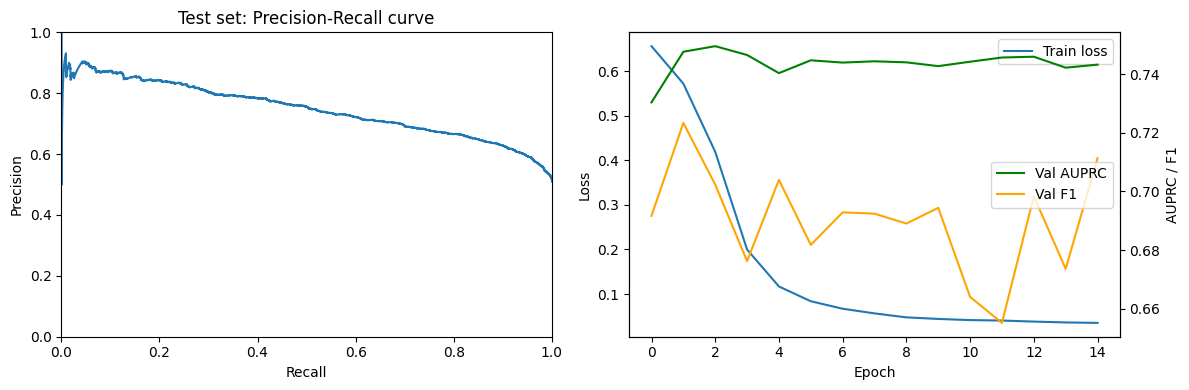

In [10]:
precision_curve, recall_curve, _ = precision_recall_curve(y_test_true, y_test_prob)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(recall_curve, precision_curve)
axes[0].set_xlabel("Recall")
axes[0].set_ylabel("Precision")
axes[0].set_title("Test set: Precision-Recall curve")
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0, 1])

axes[1].plot(history["train_loss"], label="Train loss")
ax2 = axes[1].twinx()
ax2.plot(history["val_auprc"], color="green", label="Val AUPRC")
ax2.plot(history["val_f1"], color="orange", label="Val F1")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
ax2.set_ylabel("AUPRC / F1")
axes[1].legend(loc="upper right")
ax2.legend(loc="center right")
plt.tight_layout()
plt.show()

## 9. Inspect common failure modes

We identify high-confidence errors (false positives and false negatives) and show a few example windows and their predicted probabilities to build intuition for model limitations.

In [11]:
y_pred = (y_test_prob >= 0.5).astype(int)
fp_mask = (y_pred == 1) & (y_test_true == 0)
fn_mask = (y_pred == 0) & (y_test_true == 1)

# Indices of top-confidence false positives and false negatives
fp_scores = y_test_prob[fp_mask]
fp_idx = np.where(fp_mask)[0][np.argsort(fp_scores)[-10:][::-1]]
fn_scores = y_test_prob[fn_mask]
fn_idx = np.where(fn_mask)[0][np.argsort(fn_scores)[:10]]

print("Sample high-confidence false positives (pred=1, true=0):")
for i in fp_idx[:5]:
    seq = test_df["original_sequence"].iloc[i]
    center = seq[len(seq) // 2] if len(seq) else "?"
    print(f"  center={center} prob={y_test_prob[i]:.3f} | {seq[:40]}...")

print("\nSample high-confidence false negatives (pred=0, true=1):")
for i in fn_idx[:5]:
    seq = test_df["original_sequence"].iloc[i]
    center = seq[len(seq) // 2] if len(seq) else "?"
    print(f"  center={center} prob={y_test_prob[i]:.3f} | {seq[:40]}...")

Sample high-confidence false positives (pred=1, true=0):
  center=K prob=1.000 | ECGKIFRHSSLLIEHQALHAGEEPYKCNERGKSFRHNSTL...
  center=K prob=1.000 | ECGKAFTQSSCLSIHRRVHTGEKPYRCGECGKAFAQKANL...
  center=K prob=0.993 | SLLIEHQALHAGEEPYKCNERGKSFRHNSTLKIHQRVHSG...
  center=K prob=0.993 | TTGKKLCYKGSTFHRVVKNFMIQGGDFSEGNGKGGESIYG...
  center=K prob=0.992 | SVQGHASEEKLISSAKQVAASTAQLLVACKVKADQDSEAM...

Sample high-confidence false negatives (pred=0, true=1):
  center=K prob=0.001 | VGIVVNKQVKGKILAKRINVRIEHIKHSKSRDSFLKRVKE...
  center=K prob=0.002 | KLLRKRSQVWKPKVIRISARSGEGISEMWDKMKDFQDLML...
  center=K prob=0.002 | AKDAASAGLGSIGVKFSRDRESRSPFLKPDERAPTEMAKA...
  center=K prob=0.002 | IKGMHIRKATKYLKDVTLQKQCVPFRRYNGGVGRCAQAKQ...
  center=K prob=0.003 | NFPTASVEGKEEKKGRRMKSKPKDKDSKKTKTCSKLKEKT...


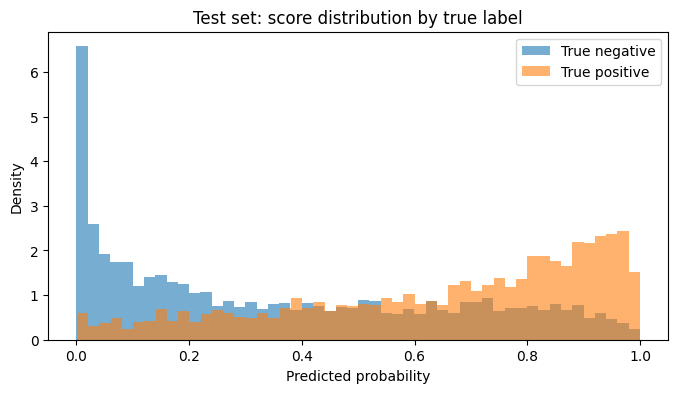

In [12]:
# Predicted score distribution by true label
fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(y_test_prob[y_test_true == 0], bins=50, alpha=0.6, label="True negative", density=True)
ax.hist(y_test_prob[y_test_true == 1], bins=50, alpha=0.6, label="True positive", density=True)
ax.set_xlabel("Predicted probability")
ax.set_ylabel("Density")
ax.set_title("Test set: score distribution by true label")
ax.legend()
plt.show()

## 10. Refactored functions for hyperparameter search

The functions below wrap the pipeline logic for reuse in hyperparameter tuning. They accept hyperparameters as arguments and return training history and test metrics.

In [13]:
def train_mlp_pipeline(
    X_train, y_train, X_val, y_val, X_test, y_test,
    hidden_dims=(512, 256),
    dropout=0.3,
    learning_rate=1e-3,
    batch_size=256,
    num_epochs=15,
    pos_weight=None,
    device=None,
    verbose=True,
    seed=42
):
    """
    Train MLP pipeline with given hyperparameters.
    
    Returns:
        dict with keys: 'history', 'test_metrics', 'best_val_auprc', 'model_state'
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    if pos_weight is None:
        n_pos = y_train.sum()
        n_neg = len(y_train) - n_pos
        pos_weight = float(n_neg) / max(n_pos, 1)
    
    # Set seeds
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
    
    # Create datasets and loaders
    train_ds = WindowDataset(X_train, y_train)
    val_ds = WindowDataset(X_val, y_val)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=0)
    
    # Create model
    input_dim = X_train.shape[1]
    model = MLP(input_dim, hidden_dims=hidden_dims, dropout=dropout).to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight], device=device))
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Training loop
    best_val_auprc = 0.0
    best_state = None
    history = {"train_loss": [], "val_auprc": [], "val_f1": [], "val_precision": [], "val_recall": []}
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            logits = model(X)
            loss = criterion(logits, y.squeeze(1))
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        train_loss = running_loss / len(train_loader)
        history["train_loss"].append(train_loss)
        
        y_val_true, y_val_prob, val_metrics = evaluate(model, val_loader, device)
        history["val_auprc"].append(val_metrics["auprc"])
        history["val_f1"].append(val_metrics["f1"])
        history["val_precision"].append(val_metrics["precision"])
        history["val_recall"].append(val_metrics["recall"])
        
        if val_metrics["auprc"] > best_val_auprc:
            best_val_auprc = val_metrics["auprc"]
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        
        if verbose and (epoch + 1) % 5 == 0:
            print(
                f"Epoch {epoch+1}/{num_epochs} | train_loss={train_loss:.4f} | "
                f"val P={val_metrics['precision']:.3f} R={val_metrics['recall']:.3f} "
                f"F1={val_metrics['f1']:.3f} AUPRC={val_metrics['auprc']:.3f}"
            )
    
    # Load best model and evaluate on test set
    model.load_state_dict(best_state)
    test_loader = DataLoader(
        WindowDataset(X_test, y_test), batch_size=batch_size, shuffle=False, num_workers=0
    )
    y_test_true, y_test_prob, test_metrics = evaluate(model, test_loader, device)
    
    return {
        "history": history,
        "test_metrics": test_metrics,
        "best_val_auprc": best_val_auprc,
        "model_state": best_state,
        "y_test_true": y_test_true,
        "y_test_prob": y_test_prob
    }